# 차원축소

- 다차원의 데이터 셋의 차원을 축소해 새로운 차원의 데이터 셋을 생성하는 것
- 다중공선성 해소, 학습속도
- 이미지나 텍스트 데이터
- PCA, LDA, SVD, NMF 등

## PCA (Principal Component Analysis)

- 여러 변수간에 존재하는 상관관계를 이용
- 데이터의 분산이 최대가 되게하는 벡터 축을 잡고 그것에 직각이 되게 축 추가
- 입력 데이터의 공분산 행렬이 고유벡터와 고유값으로 분해될 수 있으며, 고유벡터를 이용해 입력데이터를 선형 변환하는 방식이 PCA

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
%matplotlib inline

In [2]:
iris = load_iris()
columns = ['sepal_length','sepal_width','petal_length','petal_width']

iris_df = pd.DataFrame(iris.data, columns=columns)
iris_df['target'] = iris.target

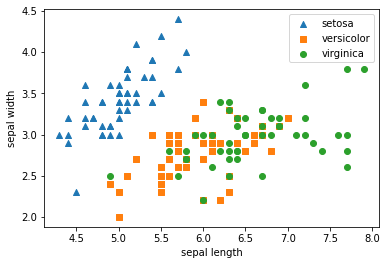

In [4]:
markers = ['^','s','o']

# 차원이 4개인 아이리스 데이터에서 두개의 피처만을 뽑아 데이터 분포 시각화

for i, marker in enumerate(markers):
  x_axis = iris_df[iris_df['target']==i]['sepal_length']
  y_axis = iris_df[iris_df['target']==i]['sepal_width']
  plt.scatter(x_axis, y_axis, marker=marker, label=iris.target_names[i])

plt.legend()
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.show()

In [19]:
# PCA는 데이터의 스케일에 영향을 받기 때문에 PCA 전 스케일링을 해야한다.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
iris_scaled = scaler.fit_transform(iris_df.iloc[:,:-1]) # 마지막 컬럼이 타겟변수이니까 마지막은 제외  == iris_df.drop('target', axis=1)

In [20]:
# PCA수행


# 1번. 몇개의 주성분으로 분해할지 미리 정하고 수행
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pca.fit(iris_scaled)
iris_pca = pca.transform(iris_scaled)

# iris_pca 에는 두개의 주성분으로 이루어진 좌표들이 있다.(comp1, comp2)

# PCA수행한 새로운 데이터 생성(추후에 모델링이 필요하면 이 데이터에서 사용)
pca_col = ['Comp_1','Comp_2']
iris_df_pca = pd.DataFrame(iris_pca, columns=pca_col)
iris_df_pca['target']=iris.target


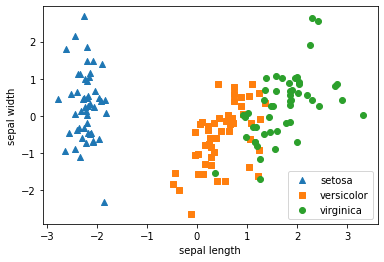

In [21]:
markers = ['^','s','o']

# PCA 수행 후 새로운 분포 시각화

for i, marker in enumerate(markers):
  x_axis = iris_df_pca[iris_df_pca['target']==i]['Comp_1']
  y_axis = iris_df_pca[iris_df_pca['target']==i]['Comp_2']
  plt.scatter(x_axis, y_axis, marker=marker, label=iris.target_names[i])

plt.legend()
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.show()

In [22]:
# 개별 컴포넌트 별 차지하는 변동성 비율
print(pca.explained_variance_ratio_)

[0.72962445 0.22850762]


In [34]:
# 컴포넌트 구성에 영향을 끼치는 변수 계수
pca.components_

array([[ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654],
       [ 0.37741762,  0.92329566,  0.02449161,  0.06694199]])

In [25]:
# 2. Scree plot 그리고 몇 개의 컴포넌트 사용할지 고르기

# 고윳값의 값이 0.7보다 크고 누적 기여율이 80% 이상이면 고려
# 여기서는 2개의 컴포넌트를 사용하는것이 바람직해 보임
from sklearn.decomposition import PCA

pca2 = PCA()

pca2.fit(iris_scaled)
iris_pca2 = pca2.transform(iris_scaled)

result = pd.DataFrame({'설명가능한 분산 비율(고윳값)':pca2.explained_variance_,
             '기여율':pca2.explained_variance_ratio_},
            index=np.array([f"pca{num+1}" for num in range(iris_scaled.shape[1])]))

result['누적기여율'] = result['기여율'].cumsum()
result


,설명가능한 분산 비율(고윳값),기여율,누적기여율
pca1,2.938085,0.729624,0.729624
pca2,0.920165,0.228508,0.958132
pca3,0.147742,0.036689,0.994821
pca4,0.020854,0.005179,1.000000


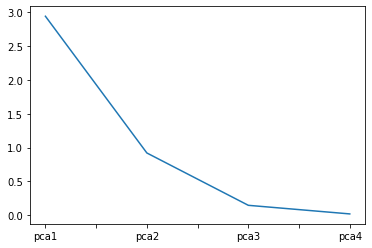

In [24]:
result['설명가능한 분산 비율(고윳값)'].plot()

In [28]:
# 차원 축소한 데이터를 기계학습 시키기
# 랜덤포레스트 사용하여 분류

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(random_state=156)
scores = cross_val_score(rf, iris.data, iris.target, scoring='accuracy',cv=3)
print('원본데이터 교차검증 개별 정확도 : ', scores)
print('원본데이터 평균 정확도 : ', np.mean(scores))

scores_pca = cross_val_score(rf, iris_df_pca.drop('target',axis=1), iris_df_pca['target'], scoring='accuracy', cv=3)
print('PCA데이터 교차검증 개별 정확도 : ', scores_pca)
print('PCA데이터 평균 정확도 : ', np.mean(scores_pca))

원본데이터 교차검증 개별 정확도 :  [0.98 0.94 0.96]
원본데이터 평균 정확도 :  0.96
PCA데이터 교차검증 개별 정확도 :  [0.88 0.88 0.88]
PCA데이터 평균 정확도 :  0.88


## LDA (Linear Disciminant Analysis)

- PCA와 유사하지만 가장 큰 차이점은 지도학습의 분류 문제에서 개별 클래스를 분별할 수 있는 기준을 최대한 유지하면서 차원축소
- 클래스간 분산은 최대한으로 만들고 클래스 내 분산은 최소로 만드는 방식
- PCA는 공분산행렬을 사용하지만 LDA는 클래스간 분산과 클래스내 분산 행렬을 생성한 뒤 이 행렬에 기반해 고유벡터를 구하고 입력데이터를 투영한다.

In [30]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

iris = load_iris()
iris_scaled = StandardScaler().fit_transform(iris.data)

lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(iris_scaled, iris.target) # PCA와 다르게 타겟데이터가 들어간다.
iris_lda = lda.transform(iris_scaled)

lda_col = ['Comp_1','Comp_2']
iris_df_lda = pd.DataFrame(iris_lda, columns=lda_col)
iris_df_lda['target'] = iris.target

## SVD (Singular Value Decomposition) 특잇값 분해

- PCA는 정방행렬을 사용했다면 SVD는 m x n 행렬을 사용
- numpy 와 scipy 로 수학적으로 행렬의계산으로 할 수 있으나 사이킷런의 TruncatedSVD 사용
- PCA가 SVD 알고리즘으로 구현됐기 때문에 둘이 비슷하나 PCA는 밀집행렬에 대한 변환만 가능하다면 SVD는 희소행렬에 대한 변환도 가능

In [32]:
from sklearn.decomposition import TruncatedSVD

iris = load_iris()
iris_scaled = StandardScaler().fit_transform(iris.data)

tsvd = TruncatedSVD(n_components=2)
tsvd.fit(iris_scaled)
iris_tsvd = tsvd.transform(iris_scaled)

## NMF (Non-Negative Matrix Factorization)

- SVD와 유사하지만 원본 행렬 내의 모든 원소 값이 모두 양수라는게 보장되면 좀 더 간단하게 두개의 기반 양수 행렬로 분해할 수 있는 기법

In [38]:
from sklearn.decomposition import NMF

nmf = NMF(n_components=2)
nmf.fit(iris.data) # 음수값이 있는 데이터는 사용 불가
iris_nmf = nmf.transform(iris.data)